<a href="https://colab.research.google.com/github/kourosh89/TimeSeries-LSTM-on-BITCOIN/blob/main/Github_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import numpy as np
import pandas as pd
import os, shutil
import matplotlib.pyplot as plt
# import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense , Bidirectional
from tensorflow.keras.layers import TimeDistributed, Conv1D, Conv2D, Conv3D
from tensorflow.keras.layers import ConvLSTM1D, ConvLSTM2D, MaxPool1D, MaxPool2D
from tensorflow.keras.layers import MaxPool3D, Flatten, RepeatVector

In [ ]:
df = pd.read_csv('/content/BTC-Daily.csv')

I Extracted data for BITCOIN regarding to 2014-11-28 to 2022-03-01


we can use some method in Pandas to have overall overview about data

In [ ]:
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


In [ ]:
df = df.sort_values(['date']).reset_index().drop(['index'],axis=1)

In [ ]:
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1417132800,2014-11-28 00:00:00,BTC/USD,363.59,381.34,360.57,376.28,3220878.18,8617.15
1,1417219200,2014-11-29 00:00:00,BTC/USD,376.42,386.60,372.25,376.72,2746157.05,7245.19
2,1417305600,2014-11-30 00:00:00,BTC/USD,376.57,381.99,373.32,373.34,1145566.61,3046.33
3,1417392000,2014-12-01 00:00:00,BTC/USD,376.40,382.31,373.03,378.39,2520662.37,6660.56
4,1417478400,2014-12-02 00:00:00,BTC/USD,378.39,382.86,375.23,379.25,2593576.46,6832.53


In [ ]:
df.drop(['unix','date','symbol'],axis=1,inplace=True)
df.head(3)

,open,high,low,close,Volume BTC,Volume USD
0,363.59,381.34,360.57,376.28,3220878.18,8617.15
1,376.42,386.60,372.25,376.72,2746157.05,7245.19
2,376.57,381.99,373.32,373.34,1145566.61,3046.33


we need to check type of series in the dataframe. if anyone would not be float, it should be changed to float.

we also need to check missing value

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open        2651 non-null   float64
 1   high        2651 non-null   float64
 2   low         2651 non-null   float64
 3   close       2651 non-null   float64
 4   Volume BTC  2651 non-null   float64
 5   Volume USD  2651 non-null   float64
dtypes: float64(6)
memory usage: 124.4 KB


In [ ]:
df.describe()

,open,high,low,close,Volume BTC,Volume USD
count,2651.000000,2651.000000,2651.000000,2651.000000,2.651000e+03,2.651000e+03
mean,11693.189332,12038.562912,11296.539461,11709.326213,1.330041e+07,6.099369e+07
std,16272.554746,16739.237000,15718.297511,16282.908704,4.715366e+07,1.072838e+08
min,162.000000,212.840000,152.400000,162.000000,0.000000e+00,0.000000e+00
25%,654.680000,664.460000,640.050000,654.370000,5.357883e+03,9.516170e+03
50%,6408.950000,6540.000000,6312.000000,6407.770000,1.503310e+04,2.288982e+07
75%,10708.620000,10956.240000,10303.755000,10726.425000,3.435336e+06,8.018383e+07
max,67547.490000,69000.000000,66250.000000,67559.000000,7.723295e+08,1.446125e+09


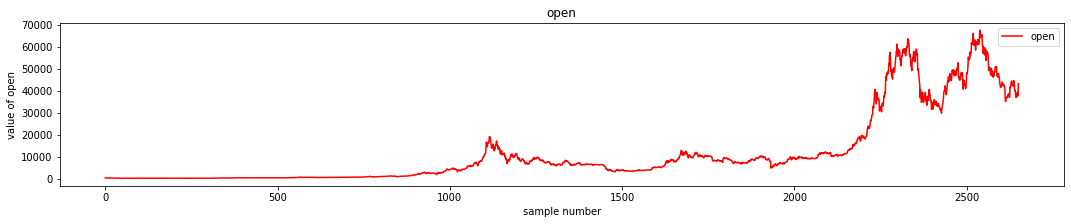

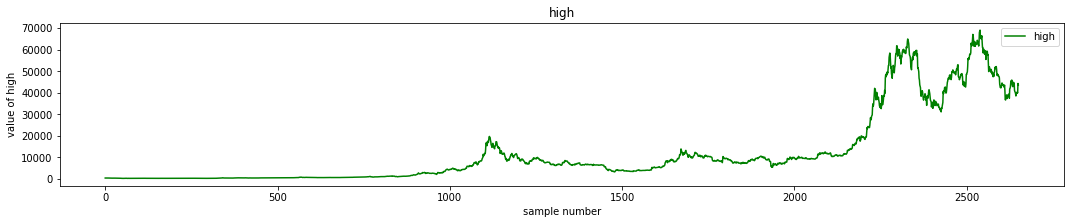

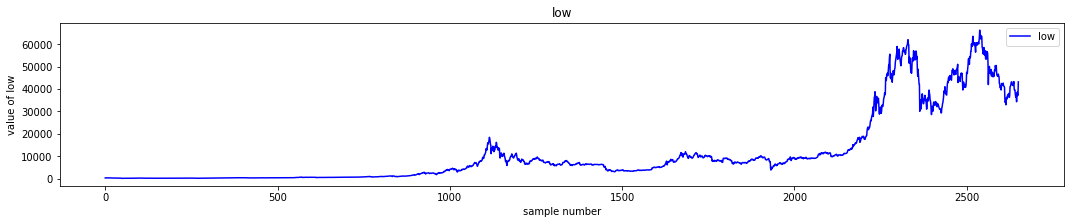

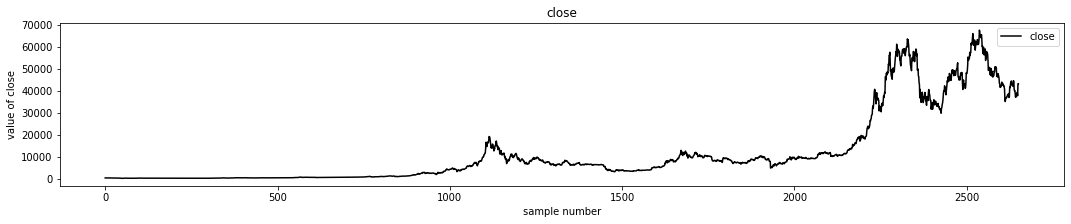

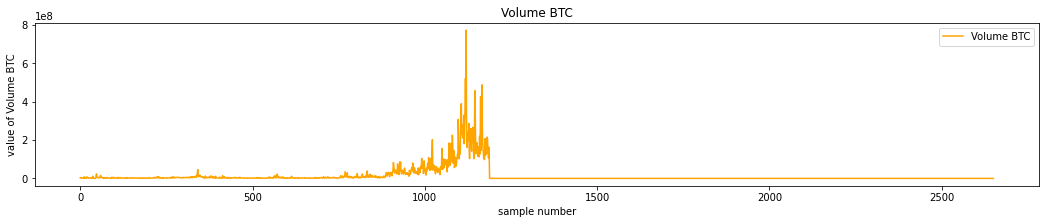

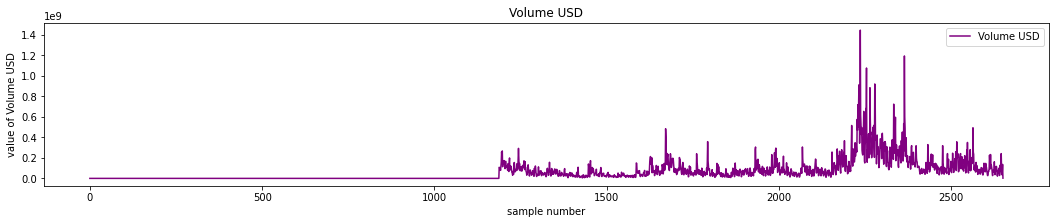

In [ ]:
a = {'open':'red','high':'green','low':'blue','close':'black','Volume BTC':'orange','Volume USD':'purple'}
for i in df.columns:
  plt.figure(figsize=(18,3))
  plt.plot(df.index , df[i] , color = a[i] , label = i)
  plt.legend()
  plt.xlabel('sample number')
  plt.ylabel('value of '+i)
  plt.title(i)
  plt.show()

In this part, we need to consider correlation between any pair value

In [ ]:
df.corr()

,open,high,low,close,Volume BTC,Volume USD
open,1.000000,0.999485,0.998983,0.998798,-0.048598,0.609992
high,0.999485,1.000000,0.998901,0.999474,-0.045371,0.617662
low,0.998983,0.998901,1.000000,0.999319,-0.056040,0.593531
close,0.998798,0.999474,0.999319,1.000000,-0.049489,0.608673
Volume BTC,-0.048598,-0.045371,-0.056040,-0.049489,1.000000,-0.160242
Volume USD,0.609992,0.617662,0.593531,0.608673,-0.160242,1.000000


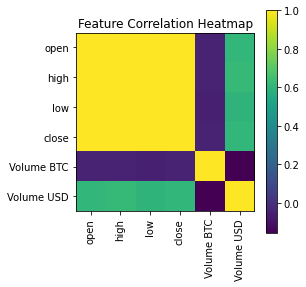

In [ ]:
plt.matshow(df.corr())
plt.xticks(range(df.shape[1]) , df.columns , rotation = 90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(df.shape[1]) , df.columns)
plt.colorbar()
plt.title("Feature Correlation Heatmap", fontsize=12)
plt.show()

In [ ]:
df_train , df_test = df[:2400] , df[2400:]

In [ ]:
train = df_train
test = df_test

In [ ]:
train.head()

,open,high,low,close,Volume BTC,Volume USD
0,363.59,381.34,360.57,376.28,3220878.18,8617.15
1,376.42,386.60,372.25,376.72,2746157.05,7245.19
2,376.57,381.99,373.32,373.34,1145566.61,3046.33
3,376.40,382.31,373.03,378.39,2520662.37,6660.56
4,378.39,382.86,375.23,379.25,2593576.46,6832.53


In [ ]:
scalers={}
for i in train.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    ss = scaler.fit_transform(train[i].values.reshape(-1,1))
    scalers['scaler_'+ i] = scaler
    train[i]=ss

for i in train.columns:
    ss = scaler.fit_transform(test[i].values.reshape(-1,1))
    test[i]=ss

<ipython-input-17-8ddc747284c0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=ss
<ipython-input-17-8ddc747284c0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=ss
<ipython-input-17-8ddc747284c0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t

In [ ]:
scalers

{'scaler_open': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_high': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_low': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_close': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_Volume BTC': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_Volume USD': MinMaxScaler(feature_range=(-1, 1))}

In [ ]:
print (train.shape)
print (test.shape)

(2400, 6)
(251, 6)


In [ ]:
n_past = 60
n_future = 7
n_features = 6

In [ ]:
def data_maker(data , n_past , n_future):
  x = []
  y = []
  n_sample = len(data)-(n_past+n_future)+1
  for i in range(n_sample):
    x.append(data[i:i+n_past])
    y.append(data[i+n_past:i+n_past+n_future])
  return np.array(x) , np.array(y)

In [ ]:
x_train , y_train = data_maker(train , n_past , n_future)
x_test , y_test = data_maker(test , n_past , n_future)

In [ ]:
print ('shape of x_train is {} and shape of y_train is {}'.format(x_train.shape , y_train.shape))
print ('shape of x_test is {} and shape of y_test is {}'.format(x_test.shape , y_test.shape))

shape of x_train is (2334, 60, 6) and shape of y_train is (2334, 7, 6)
shape of x_test is (185, 60, 6) and shape of y_test is (185, 7, 6)


Designing Model:

In [ ]:
model0 = Sequential()
model0.add(tf.keras.layers.Input(shape = (60,6)))
model0.add(Conv1D(64,3,activation='relu'))
model0.add(Conv1D(64,3,activation='relu'))
model0.add(Flatten())
model0.add(RepeatVector(7))
model0.add(LSTM(200 , activation = 'relu', return_sequences=True))
model0.add(TimeDistributed(Dense(100,activation='relu')))
model0.add(TimeDistributed(Dense(6)))
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 64)            1216      
                                                                 
 conv1d_1 (Conv1D)           (None, 56, 64)            12352     
                                                                 
 flatten (Flatten)           (None, 3584)              0         
                                                                 
 repeat_vector (RepeatVector  (None, 7, 3584)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 7, 200)            3028000   
                                                                 
 time_distributed (TimeDistr  (None, 7, 100)           20100     
 ibuted)                                                

In [ ]:
myfilepath="model_final_1.h5"
my_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x),
    ModelCheckpoint(myfilepath, monitor='val_loss', verbose=1,save_best_only=True, mode='min', save_freq='epoch') ]
model0.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
history_e2d2=model0.fit(x_train,y_train,epochs=30,validation_data=(x_test,y_test),batch_size=64,verbose=1,callbacks=my_callbacks)

Epoch 1/30
37/37 [==============================] - ETA: 0s - loss: 0.1298
Epoch 1: val_loss improved from inf to 0.09605, saving model to model_final_1.h5
37/37 [==============================] - 15s 313ms/step - loss: 0.1298 - val_loss: 0.0960 - lr: 0.0010
Epoch 2/30
37/37 [==============================] - ETA: 0s - loss: 0.0062
Epoch 2: val_loss improved from 0.09605 to 0.09020, saving model to model_final_1.h5
37/37 [==============================] - 11s 301ms/step - loss: 0.0062 - val_loss: 0.0902 - lr: 9.0000e-04
Epoch 3/30
37/37 [==============================] - ETA: 0s - loss: 0.0051
Epoch 3: val_loss improved from 0.09020 to 0.08338, saving model to model_final_1.h5
37/37 [==============================] - 11s 287ms/step - loss: 0.0051 - val_loss: 0.0834 - lr: 8.1000e-04
Epoch 4/30
37/37 [==============================] - ETA: 0s - loss: 0.0041
Epoch 4: val_loss improved from 0.08338 to 0.08045, saving model to model_final_1.h5
37/37 [==============================] - 13s 36

In [ ]:
print(x_train.shape)
print(x_test.shape)

(2334, 60, 6)
(185, 60, 6)


In [ ]:
prediction_train = model0.predict(x_train)
prediction_test = model0.predict(x_test)

6/6 [==============================] - 0s 45ms/step


In [ ]:
prediction_test[0]

array([[-0.2951012 , -0.27113092, -0.29982284, -0.32222337, -0.5069975 ,
        -0.5286126 ],
       [-0.28391895, -0.22390562, -0.24592951, -0.32330585, -0.5420613 ,
        -0.58907473],
       [-0.25364628, -0.1802051 , -0.19291173, -0.29614577, -0.54458195,
        -0.6019281 ],
       [-0.2243115 , -0.16186063, -0.1802082 , -0.27249104, -0.5337507 ,
        -0.5916134 ],
       [-0.20127396, -0.15540154, -0.17637686, -0.26044106, -0.5204191 ,
        -0.58573854],
       [-0.20288084, -0.16015767, -0.1747578 , -0.26258698, -0.527864  ,
        -0.5849159 ],
       [-0.2098553 , -0.15955405, -0.17659895, -0.26864475, -0.53748876,
        -0.5846944 ]], dtype=float32)

In [ ]:
print(y_train.shape)
print(y_test.shape)
print(prediction_train.shape)
print(prediction_test.shape)

(2334, 7, 6)
(185, 7, 6)
(2334, 7, 6)
(185, 7, 6)


In [ ]:
scalers

{'scaler_open': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_high': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_low': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_close': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_Volume BTC': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_Volume USD': MinMaxScaler(feature_range=(-1, 1))}

In [ ]:
for index,i in enumerate(df_train.columns):
    scaler = scalers['scaler_'+i]
    prediction_train[:,:,index]=scaler.inverse_transform(prediction_train[:,:,index])
    prediction_test[:,:,index]=scaler.inverse_transform(prediction_test[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [ ]:
y_train[3]

array([[2.34750000e+02, 2.44980000e+02, 2.27260000e+02, 2.32600000e+02,
        4.65356437e+06, 2.12310051e+06],
       [2.32600000e+02, 2.34800000e+02, 2.15750000e+02, 2.17980000e+02,
        4.49452982e+06, 2.12305772e+06],
       [2.17980000e+02, 2.20810000e+02, 2.08480000e+02, 2.14800000e+02,
        1.33658685e+06, 2.11846357e+06],
       [2.14800000e+02, 2.41980000e+02, 2.14800000e+02, 2.37970000e+02,
        1.49477857e+06, 2.11854329e+06],
       [2.37970000e+02, 2.44390000e+02, 2.23790000e+02, 2.27350000e+02,
        4.17819928e+06, 2.12239510e+06],
       [2.27350000e+02, 2.31000000e+02, 2.20020000e+02, 2.27000000e+02,
        3.22039110e+06, 2.12122477e+06],
       [2.27000000e+02, 2.28940000e+02, 2.13640000e+02, 2.17000000e+02,
        9.53936470e+05, 2.11782635e+06]])

In [ ]:
# y_test=scaler.inverse_transform(y_test)
# prediction_test=scaler.inverse_transform(prediction_test)

In [ ]:
prediction_test[2]

array([[2.47403691e+04, 2.52537695e+04, 2.34547891e+04, 2.36064492e+04,
        1.98813488e+08, 1.21829648e+08],
       [2.55835527e+04, 2.71173105e+04, 2.56158320e+04, 2.39079883e+04,
        1.88181312e+08, 1.06886184e+08],
       [2.67314453e+04, 2.85419043e+04, 2.74767246e+04, 2.49658750e+04,
        1.91048592e+08, 1.04537776e+08],
       [2.77851641e+04, 2.90573945e+04, 2.79925723e+04, 2.56958691e+04,
        1.96564368e+08, 1.07583624e+08],
       [2.83408301e+04, 2.97083340e+04, 2.84632832e+04, 2.61409102e+04,
        2.04172016e+08, 1.12337208e+08],
       [2.84737930e+04, 2.99365938e+04, 2.86735430e+04, 2.61028359e+04,
        2.05185968e+08, 1.13534328e+08],
       [2.83159160e+04, 3.00025332e+04, 2.86468574e+04, 2.58722676e+04,
        2.02900720e+08, 1.13744544e+08]], dtype=float32)